## Making Yelp Experts
### By: Reilly Proudsworth

### Background:

Almost since its launch in 2004, the Yelp service has been plagued with reports related to [unfair manipulation](https://www.wsj.com/articles/yelp-regularly-receives-subpoenas-about-users-1396467536?tesla=y) of their 5-star rating system.  Some of the accusations are related to [external perpetrators](http://www.huffingtonpost.com/2012/12/03/yelp-ceo-jeremy-stoppelman-_n_2232091.html), businesses looking to astroturf or leave false reviews about competetors in order to boost business.  To combat those groups, Yelp deployed a proprietary algorithm which [filters out suspect reviews automatically](http://fortune.com/2013/09/26/yelps-fake-review-problem/).

Unfortunately, the proprietary nature of their algorithm brought on accusations that Yelp is [internally modifying ratings](https://www.theregister.co.uk/2008/08/13/yelp_sales_pitch/) in order to sell more advertising on the popular website.  Yelp has been unwilling to share the filtering algorithm, claiming that astroturfing companies would use that information to circumvent the filter.  At this time, all court cases against Yelp have been dismissed and the company [attempts to improve its public image](http://www.latimes.com/business/la-fi-yelp-town-hall-20130822,0,4360994.story).

### Purpose:

The purpose of this analysis is to create a new 'expert' feature which would be used to rate businesses.  This could be a publicly known rating algorithm, eliminating the secrecy and offering transparancy into how a star value is derived. 

**Initialize the required tools for analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Import cleaned/munged data**

In [3]:
df = pd.read_csv('yelp_merged_data.csv', index_col=0, dtype={37:str, 38:str}, encoding='iso-8859-1')
pd.set_option('display.max_columns', 1300)

C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Visual review of the combined dataset**

In [4]:
print(df.shape)
df.head(n=3)

(994208, 1244)


,business_id,date,stars_user,user_id,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,elite,fans,friends,funny,name_user,review_count_user,type_user,useful,yelping_since,index,address,attributes,categories,city,hours,is_open,latitude,longitude,name_bus,neighborhood,postal_code,review_count_bus,stars_bus,state,type_bus,Environmental Testing,IV Hydration,Art Restoration,Backshop,Pulmonologist,Workers Compensation Law,Dentists,Tennis,Czech,LAN Centers,Caribbean,Public Transportation,Cannabis Tours,Linens,Beer,Market Stalls,Duty-Free Shops,Leisure Centers,3D Printing,Town Car Service,Club Crawl,Midwives,Powder Coating,First Aid Classes,Street Art,Party Bus Rentals,Periodontists,Gymnastics,Cosmetic Surgeons,Embroidery & Crochet,Korean,Breakfast & Brunch,Cosmetology Schools,Gas & Service Stations,Internal Medicine,Golf Equipment,Shoe Shine,Waxing,Banks & Credit Unions,Seafood Markets,Storefront Clinics,Casinos,Watches,Childbirth Education,Auto Detailing,Soul Food,Surgeons,Flooring,Vehicle Shipping,Laboratory Testing,Horse Boarding,Orthopedists,Prosthodontists,Rest Stops,Scavenger Hunts,Christmas Markets,Nightlife,Filipino,Water Delivery,Tanning,Printing Services,Carpet Installation,Skating Rinks,Family Practice,Party Bike Rentals,Burgers,Acne Treatment,Popcorn Shops,Tutoring Centers,Bagels,DJs,Bespoke Clothing,Dental Hygienists,Ophthalmologists,Solar Installation,Editorial Services,Outlet Stores,Oriental,Recording & Rehearsal Studios,Auto Repair,Smog Check Stations,Auto Upholstery,Blood & Plasma Donation Centers,Scooter Tours,Fireworks,Lingerie,Candy Stores,Piercing,Cards & Stationery,Private Jet Charter,Lounges,Ukrainian,Caricatures,Greek,Party Equipment Rentals,Pedicabs,Karate,Boxing,Sandwiches,Home Services,Themed Cafes,Music & Video,Car Rental,Permanent Makeup,Fashion,Auto Glass Services,Moroccan,Comic Books,Scottish,Water Stores,Car Buyers,Trusts,Halotherapy,Beer Gardens,Pop-Up Restaurants,Roofing,Fabric Stores,Tex-Mex,Meditation Centers,Food Delivery Services,Bail Bondsmen,Medical Law,Rugs,Car Wash,Transmission Repair,Circuit Training Gyms,Gyms,Gardeners,Argentine,Animal Physical Therapy,Community Gardens,Animal Shelters,Ayurveda,Apartments,Magicians,Food Banks,Legal Services,Beach Bars,Hydro-jetting,Yelp Events,Structural Engineers,Barbers,Cafes,Check Cashing/Pay-day Loans,Airports,Carpeting,Propane,Donairs,Junk Removal & Hauling,Medical Cannabis Referrals,Attraction Farms,Bookbinding,Spin Classes,Parent Cafes,Stucco Services,Homeowner Association,Ski Schools,Psychics & Astrologers,Bike Rentals,Libraries,Framing,Employment Law,Orthotics,Coffee Roasteries,Endodontists,Public Relations,Neurotologists,Delis,Pet Training,Pediatric Dentists,Arts & Crafts,Auction Houses,Delicatessen,Tours,Laser Hair Removal,CSA,Oncologist,Tapas Bars,Henna Artists,Cultural Center,Fruits & Veggies,Wholesale Stores,Used,ATV Rentals/Tours,Izakaya,Shoe Stores,Pet Breeders,Lawyers,Painters,Churches,Dominican,Clothing Rental,Food Court,Spine Surgeons,Rotisserie Chicken,Bowling,Ranches,Bars,Mountain Biking,Bike Sharing,Pool Cleaners,Security Services,French,Valet Services,Chocolatiers & Shops,Alsatian,Egyptian,Shared Office Spaces,Rheumatologists,Flatbread,Horse Equipment Shops,Mexican,Sports Medicine,Officiants,Guitar Stores,Taxidermy,Uniforms,Vegetarian,Drugstores,Dance Studios,Fitness/Exercise Equipment,Assisted Living Facilities,General Dentistry,Fondue,Chicken Shop,Photographers,Talent Agencies,Bookstores,Zoos,Doulas,Baby Gear & Furniture,Baden,Go Karts,Cideries,Session Photography,Ethic Grocery,Real Estate Services,Cooking Classes,Badminton,Day Spas,Bed & Breakfast,Acupuncture,Diagnostic Imaging,Arcades,Wheel & Rim Repair,Junkyards,Obstetricians & Gynecologists,Music Production Services,Religious Items,Emergency Medicine,Tickets,Restaurant Supplies,Bistros,House Sitters,Pawn Shops,Colombian,Canadian

**Slicing out relevant features for exploration and engineering**

In [5]:
small_df = df[['business_id', 'date', 'stars_user', 'user_id', 'review_count_user', 'city', 'name_bus', 'stars_bus', 'Restaurants', 'Mexican', 'Indian']].copy()

In [6]:
food_df = small_df[df['Mexican'] == 1]
food_df = food_df[food_df['city'] == 'Las Vegas']
food_review_count = food_df.groupby('user_id', as_index=False).size().reset_index(name='category_review_count')
food_df = food_df.merge(food_review_count, on='user_id')
user_genre_reviews = food_df.drop_duplicates(subset='user_id')
user_genre_reviews.shape

(9810, 12)

**From these numbers we can see there are a significant number of reviews for one genre of food in one city.  Actually about 1% of the total reviews are for this genre of food!  Although a segment is sliced out of the total dataset, we can expand to encompass all the data.  The data is subset here for the sake of conceptualization.**

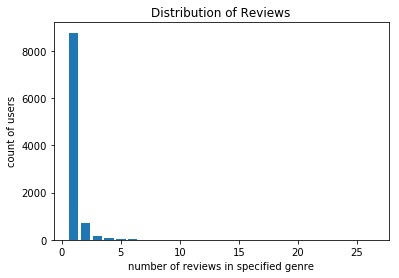

In [7]:
review_counts = user_genre_reviews['category_review_count'].value_counts()
review_counts = review_counts.reindex(np.arange(1, max(user_genre_reviews['category_review_count']) + 1), fill_value=0)
plt.bar(np.arange(1, len(review_counts) + 1), review_counts.values)
plt.title('Distribution of Reviews')
plt.xlabel('number of reviews in specified genre')
plt.ylabel('count of users')
plt.show()

#### It turns out that there is a distribution of these reviews which drops off significantly after people leave one review.

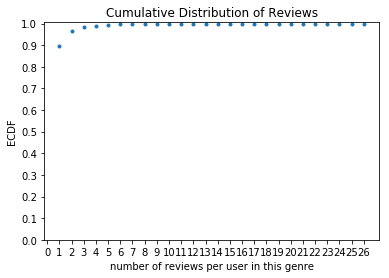

In [8]:
review_sum = review_counts.sum()
x = review_counts.index
y = []
prev_perc = 0.0
for i in review_counts:
    prev_perc = prev_perc + i / review_sum
    y.append(prev_perc)
plt.plot(x, y, marker='.', linestyle='none')
plt.title('Cumulative Distribution of Reviews')
plt.xlabel('number of reviews per user in this genre')
plt.ylabel('ECDF')
plt.xticks(np.linspace(0, len(x), len(x) + 1))
plt.yticks(np.linspace(0, 1, 11))
plt.show()

#### This cumulative distribution shows that about 98-99% of the total reviews for this genre are by users who left 4-5 reviews or less.  We need to calculate the actual threshold for users who are in the top 1%.

In [9]:
expert_threshold = 0.99 * review_sum
threshold = 0
expert_index=1
while threshold <= expert_threshold:
    threshold = threshold + review_counts[expert_index]
    expert_index = expert_index + 1

expert_index

5

**By setting an arbitrary threshold of 99%, this shows our 'experts' are users who review 5 or more Mexican restaurants in Las Vegas.  Now that we have a threshold for the number of reviews an 'expert' user leaves, would this feature even be useful in the marketplace?**

In [28]:
expert_df = food_df[food_df['category_review_count'] >= expert_index]
expert_df = expert_df[['business_id', 'stars_user', 'stars_bus']]
avg_compare_df = expert_df.groupby('business_id', as_index=False).mean()

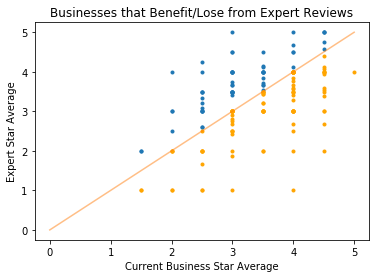

In [29]:
bus_avg = avg_compare_df['stars_bus']
exp_avg = avg_compare_df['stars_user']
mask = exp_avg > bus_avg
x = bus_avg[mask]
y = exp_avg[mask]
plt.plot(x, y, marker='.', linestyle='none')

mask = exp_avg <= bus_avg
x_below = bus_avg[mask]
y_below = exp_avg[mask]
plt.plot(x_below, y_below, color='orange', marker='.', linestyle='none')

x45 = [0, 5]
y45 = [0, 5]
plt.plot(x45, y45, alpha=0.5)
plt.title('Businesses that Benefit/Lose from Expert Reviews')
plt.xlabel('Current Business Star Average')
plt.ylabel('Expert Star Average')
plt.show()

**By using the 45 degree line, this plot makes it apparent some businesses have much higher 'expert' ratings than average user ratings.  The points above the red line benefit from this service.  We definitely have a market for this feature!**

### Conclusions:

It is apparent that there is a threshold for creating experts within a business category and that there could be a market for this feature.  Numerous businesses in just one small subset of data benefit from having a secondary review score attached to their Yelp profile.  By making this simple rating system public, users have a very easy route to understanding their reviews add up and it removes the ambiguity of the current Yelp filtering system. 

When reviewing the weaknesses of this system, writing enough fake reviews would eventually put a malicious agent within the expert category.  By combining this system with the 'check-in' data received via the Yelp app, a form of two-step authentication would occur where not only would the user have to leave the review, but a physical location dependant check-in would have to be matched on that account.  By informing users openly that this is the process to become an 'expert', users could decide for themselves if they want to strive for that title.

Ultimately, the 'Expert' feature benefits the two external parties involved in Yelp's business model.  Users are given another rating metric which can be used to find businesses that are unappreciated by the masses but loved by the experts.  Businesses are given the opportunity to try and appeal to the people who understand them best and have complete transparancy into how a rating is achieved.  By including 'Experts', Yelp offers a window into their business practices and creates an incentive for both users and businesses alike to use their service more often.